In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pyspark.sql import SparkSession
from matplotlib.lines import Line2D
from DataAnalyzer import DataAnalyzer
spark = SparkSession.builder.appName("DataAnalyzing").getOrCreate()

In [0]:
my_analyzer = DataAnalyzer(spark)
my_analyzer.load_data()

In [0]:
df = my_analyzer._df.filter(my_analyzer._df.batch_id == 'a41ca80c-8365-4f65-a103-c6852173dd1a')
df.display()

shippingAddress,batch_id,orderId,orderDate,customerId,totalAmount,paymentMethod,paymentStatus,orderStatus,productId,quantity,item_id,item_name,item_unit_price,crypto_currency,usd_rate,totalAmountUSD,city,postal_code,country


Setup SQL Database for alerting system.

In [0]:
spark.sql("CREATE DATABASE IF NOT EXISTS orders.analyzer")

DataFrame[]

In [0]:
my_analyzer.analyze()

Visualizations :

Fraud Suspected : 

/root/.ipykernel/22009/command-1944731854865775-532935881:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(my_analyzer.fraud_df.pivot('window_day', 'window_hour', 'number_of_customers'), annot=True, fmt='.0f', cmap='YlGnBu')


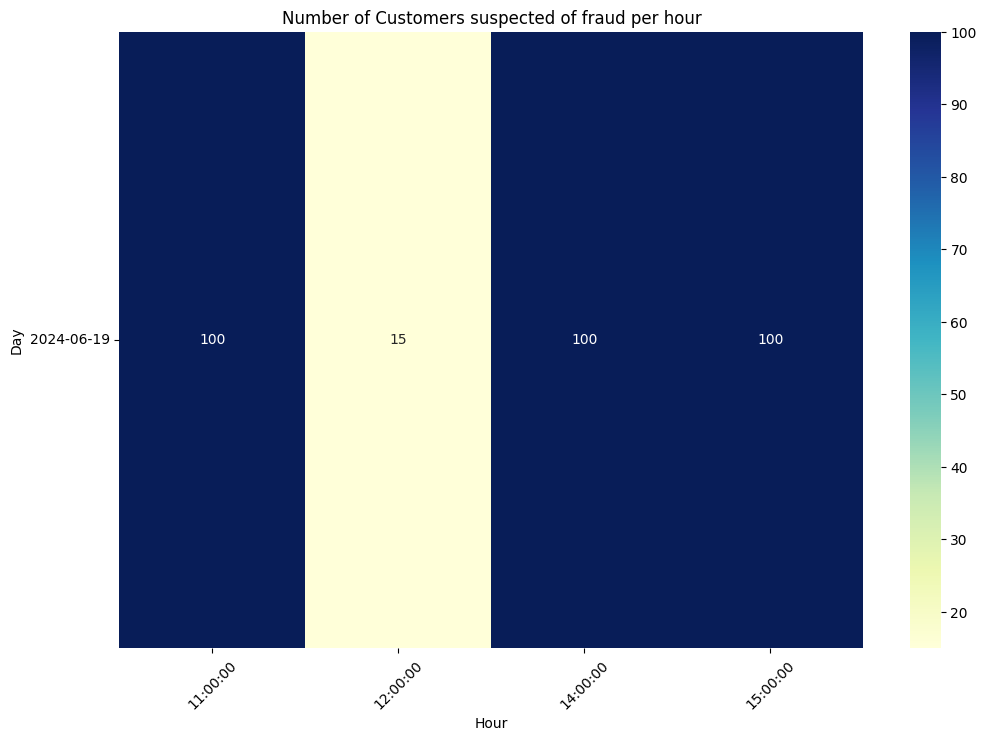

In [0]:
if my_analyzer.fraud_df.shape[0] > 0 :
    plt.figure(figsize=(12, 8))
    sns.heatmap(my_analyzer.fraud_df.pivot('window_day', 'window_hour', 'number_of_customers'), annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Number of Customers suspected of fraud per hour')
    plt.xlabel('Hour')
    plt.ylabel('Day')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

Client per Segment:

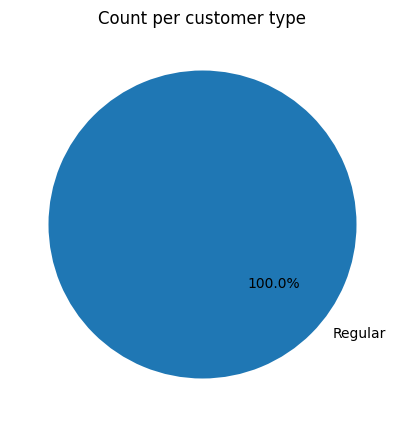

In [0]:
plt.figure(figsize=(5, 5))
plt.pie(my_analyzer.segment_df['count'], labels=my_analyzer.segment_df['segment'], autopct='%1.1f%%', startangle=140)
plt.title('Count per customer type')
plt.show()

Orders per cities: 

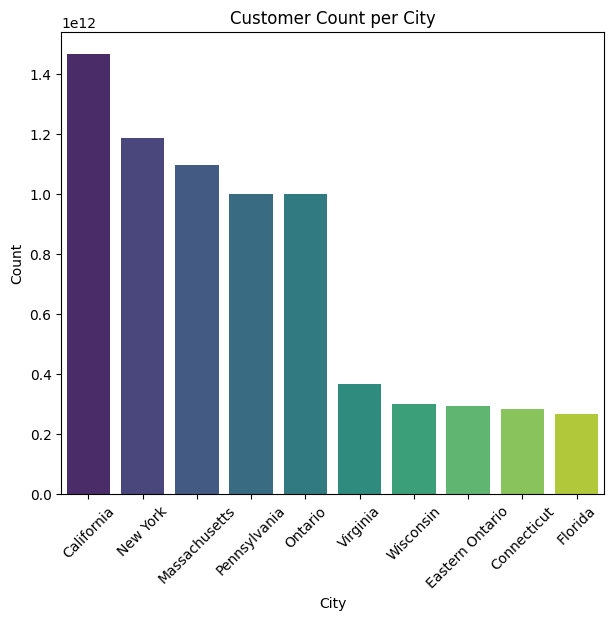

In [0]:
plt.figure(figsize=(7, 6))
sns.barplot(x='city', y='sum(totalAmountUSD)', data=my_analyzer.cities_per_amount, palette='viridis')
plt.title('Customer Count per City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Amount per countries:

/root/.ipykernel/22009/command-1944731854865781-697119438:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


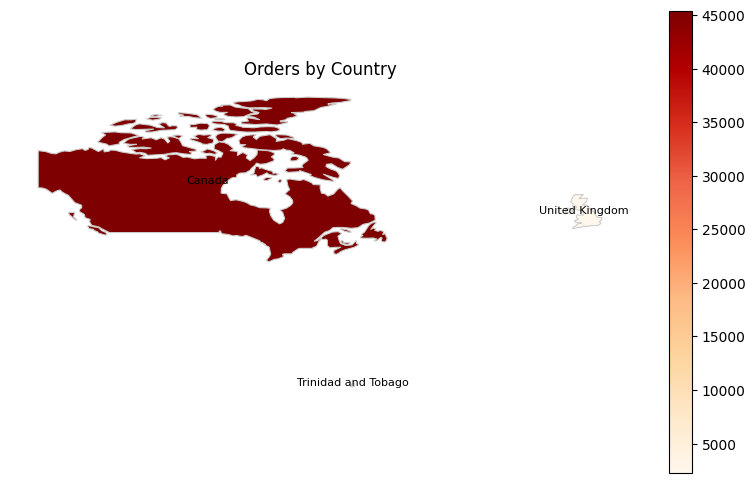

In [0]:
# Load world map data from geopandas datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the world geometries
merged = world.merge(my_analyzer.countries_per_order, how='left', left_on='name', right_on='country')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
merged.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add country names
for idx, row in merged.iterrows():
    if pd.notnull(row['count']):  # Only annotate countries with data
        plt.annotate(text=row['name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', fontsize=8)

# Customize plot
ax.set_title('Orders by Country')
ax.set_axis_off()

plt.show()

Amounts per payment method:

In [0]:
my_analyzer.amount_per_payment_method.head()

,paymentMethod,my_date,sum(totalAmountUSD)
0,CASH,2024-06-19,135294645.0
1,PAYPAL,2024-06-19,138891880.0
2,ZELLE,2024-06-19,136959980.0
3,VENMO,2024-06-19,138784985.0
4,CREDIT CARD,2024-06-19,136924805.0


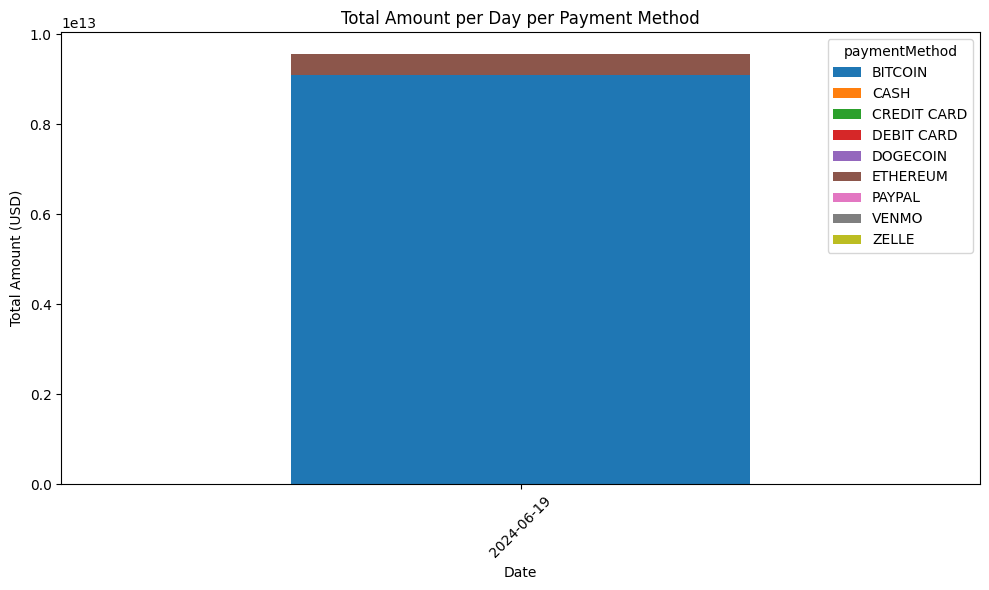

In [0]:
# Pivot the dataframe for easy plotting
pivot_df = my_analyzer.amount_per_payment_method.pivot(index='my_date', columns='paymentMethod', values='sum(totalAmountUSD)')

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Amount per Day per Payment Method')
plt.xlabel('Date')
plt.ylabel('Total Amount (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()